# Fitting models in botorch with a torch.optim.Optimizer

botorch provides a convenient `botorch.fit.fit_gpytorch_model` function with sensible defaults that work on most basic models, including those that botorch ships with. Internally, this function uses L-BFGS-B to fit the parameters. However, in more advanced uses cases you may need or want to implement your own model fitting logic.

This tutorial allows you to customize model fitting to your needs using the familiar PyTorch-style model fitting loop.

This tutorial is adapted from GPyTorch's [Simple GP Regression Tutorial](https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Simple_GP_Regression/Simple_GP_Regression.ipynb) and has very few changes because the out-of-the box models that botorch provides are GPyTorch models; in fact, they are proper subclasses that add the `botorch.models.Model` API functions.

In [1]:
import math
import torch

dtype = torch.float
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Set up function to model
In this tutorial we will model a simple sinusoidal function with i.i.d. Gaussian noise:

$$y = \sin(2\pi x) + \epsilon, ~\epsilon \sim \mathcal N(0, 0.15)$$

#### Initialize training data

In [2]:
# use regular spaced points on the interval [0, 1] (training data needs an explicit dimension)
train_X = torch.linspace(0, 1, 15, dtype=dtype, device=device).unsqueeze(1)

# sample observed values and add some synthetic noise
train_Y = torch.sin(train_X * (2 * math.pi)) + 0.15 * torch.randn_like(train_X)

# input observations must be single-dimensional for single-output model
train_Y = train_Y.view(-1)

#### Initialize the model
We will model the function using a `SingleTaskGP`, which by default uses a `GaussianLikelihood` and infers the unknown noise level.

The `SingleTaskGP` is typically fit using L-BFGS-B with explicit bounds on the noise parameter. This means that internally the model does not use a transform to ensure the noise level remains positive. Since the `torch` optimizers don't handle explicit constraints very well, we need to manually register a constraint on the noise level that enforces a lower bound using a softplus transformation (note that the constraint defined in the constructor of `SingleTask` has `transform=None`, which means that no transform is enforced). See the [GPyTorch constraints module](https://github.com/cornellius-gp/gpytorch/blob/master/gpytorch/constraints/constraints.py) for additional information.

In [3]:
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan


model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

#### Define marginal log likelihood 
We will optimizing the the kernel hyperparameters and the likelihood's noise parameter jointly by minimizing the negative `gpytorch.mlls.ExactMarginalLogLikelihood` (our loss function).

In [4]:
from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_X)

### Define optimizer and specify parameters to optimize
We will use stochastic gradient descent (`torch.optim.SGD`) to optimize the kernel hyperparameters and the noise level. In this example, we will use a simple fixed learning rate of 0.1, but in practice the learning may need to adjusted. You can use any of 

Notes:
- As the `GaussianLikelihood` module is a of child (submodule) of the `SingleTaskGP` moduel, `model.parameters()` will also include the noise level of the `GaussianLikelihood`. 
- A subset of the parameters could be passed to the optimizer to tune those parameters, while leaving the other parameters fixed.

In [5]:
from torch.optim import SGD

optimizer = SGD([{'params': model.parameters()}], lr=0.1)

### Fit model hyperparameters and noise level
Now we are ready to write our optimization loop. We will perform 100 epochs of stochastic gradient descent using our entire training set.

In [6]:
NUM_EPOCHS = 150

model.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model(train_X)
    # Compute negative marginal log likelihood
    loss = - mll(output, train_Y)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
            f"noise: {model.likelihood.noise.item():>4.3f}" 
         )
    optimizer.step()

Epoch  10/150 - Loss: 1.942 lengthscale: 0.648 noise: 2.000
Epoch  20/150 - Loss: 1.905 lengthscale: 0.605 noise: 1.856
Epoch  30/150 - Loss: 1.867 lengthscale: 0.568 noise: 1.711
Epoch  40/150 - Loss: 1.828 lengthscale: 0.537 noise: 1.564
Epoch  50/150 - Loss: 1.788 lengthscale: 0.509 noise: 1.418
Epoch  60/150 - Loss: 1.745 lengthscale: 0.485 noise: 1.273
Epoch  70/150 - Loss: 1.699 lengthscale: 0.463 noise: 1.130
Epoch  80/150 - Loss: 1.651 lengthscale: 0.443 noise: 0.992
Epoch  90/150 - Loss: 1.600 lengthscale: 0.425 noise: 0.859
Epoch 100/150 - Loss: 1.546 lengthscale: 0.407 noise: 0.735
Epoch 110/150 - Loss: 1.488 lengthscale: 0.390 noise: 0.621
Epoch 120/150 - Loss: 1.427 lengthscale: 0.372 noise: 0.517
Epoch 130/150 - Loss: 1.364 lengthscale: 0.356 noise: 0.425
Epoch 140/150 - Loss: 1.298 lengthscale: 0.341 noise: 0.345
Epoch 150/150 - Loss: 1.232 lengthscale: 0.329 noise: 0.278


### Compute posterior over test points and plot fit
We plot the posterior mean and the 2 standard deviations from the mean.

In [7]:
# set model (and likelihood)
model.eval();

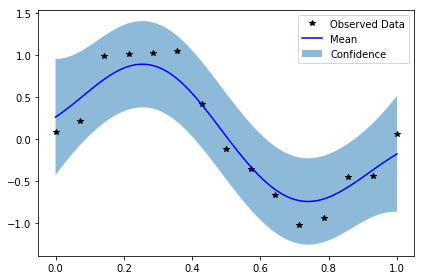

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(0, 1, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()

# Interfacing with Ax

It's simple to package up a custom optimizer loop like the one above and use it within Ax. As described in the [Using botorch with Ax tutorial](../custom_botorch_model_in_ax), this requires defining a custom `model_constructor` callable that then can ben passed to the `get_botorch` factory function.

In [9]:
def _get_and_fit_model(Xs, Ys, **kwargs):
    
    train_X, train_Y = Xs[0], Ys[0]
    model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model).to(train_X)
    model.train()
    
    optimizer = SGD([{'params': model.parameters()}], lr=kwargs.get("lr"))
    for epoch in range(kwargs.get("epochs")):
        optimizer.zero_grad()
        output = model(train_X)
        loss = -mll(output, train_Y)
        loss.backward()
        optimizer.step()
    
    return model